In [1]:
from IPython.core.display import display
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl

/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_60852/2208947901.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [2]:
np.random.seed(10)
num_places = 10
num_days = 30
num_requests = 120

mean_travel_time_to_destinations = 100
H_regular = 8*60
H_max_overtime = 3*60
c = 3000//60
W = 4000
delivery_outsourcing_unit_cost = 4600
delivery_time_window = 3
avg_weight = 1000

In [3]:
K = range(num_places)
o = 0
K_minus_o = K[1:]
_K = np.random.normal(0, mean_travel_time_to_destinations, size=(len(K), 2))
_K[o, :] = 0
t = np.array([[np.floor(np.linalg.norm(_K[k] - _K[l])) for k in K] for l in K])
D = range(num_days)
R = range(num_requests)
k = np.random.choice(K_minus_o, size=len(R))
d_0 = np.random.choice(D, size=len(R))
d_1 = d_0 + delivery_time_window - 1
w = np.floor(np.random.gamma(10, avg_weight/10, size=len(R)))
f = np.ceil(w/100) * delivery_outsourcing_unit_cost

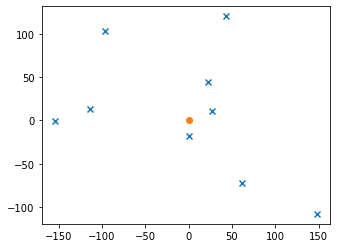

In [4]:
a = plt.subplot()
a.scatter(_K[1:, 0], _K[1:, 1], marker="x")
a.scatter(_K[0, 0], _K[0, 1], marker="o")
a.set_aspect("equal")
plt.show()

(array([ 0.,  0.,  0.,  0.,  2.,  9.,  7., 11., 14., 12., 22., 14., 14.,
         9.,  2.,  1.,  2.,  0.,  1.,  0.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000.]),
 <BarContainer object of 20 artists>)

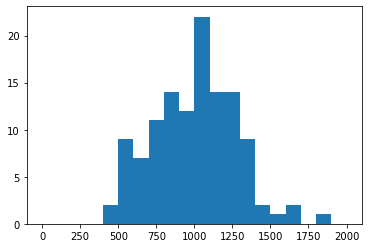

In [5]:
plt.hist(w, bins=20, range=(0, 2000))

In [6]:
import pulp
from itertools import product, combinations_with_replacement
from joblib import Parallel, delayed

def simulate_route(z):
    if z[0] == 0:
        return None
    daily_route_prob = pulp.LpProblem(sense=pulp.LpMinimize)
    x = {}
    for k, l in product(K, K):
        if k != l:
            x[k,l] = pulp.LpVariable(f"x_{k}_{l}", cat="Binary")
        else:
            x[k,l] = pulp.LpAffineExpression()   # 0
    u = {}
    for k in K_minus_o:
        u[k] = pulp.LpVariable(f"u_{k}", lowBound=1, upBound=len(K)-1)
    
    h = pulp.LpVariable("h", lowBound=0, cat="Continuous")

    for l in K:
        daily_route_prob += pulp.lpSum([x[k,l] for k in K]) <= 1
    
    for l in K:
        if z[l] == 1:
            daily_route_prob += pulp.lpSum([x[k,l] for k in K]) == 1
            daily_route_prob += pulp.lpSum([x[l,k] for k in K]) == 1
        else:
            daily_route_prob += pulp.lpSum([x[k,l] for k in K]) == 0
            daily_route_prob += pulp.lpSum([x[l,l] for k in K]) == 0
    
    for k, l in product(K_minus_o, K_minus_o):
        daily_route_prob += (u[k] + 1 <= u[l] + len(K_minus_o) * (1-x[k,l]))
    
    travel = pulp.lpSum([t[k, l] * x[k, l] for k, l in product(K, K)])
    daily_route_prob += (travel - H_regular <= h)
    daily_route_prob += (h <= H_max_overtime)

    daily_route_prob += travel
    daily_route_prob.solve(pulp.PULP_CBC_CMD(msg=0))

    return{
        "z":z,
        "route":{
            (k,l):x[k,l].value()
            for k, l in product(K, K)
        },
        "optimal":daily_route_prob.status==1,
        "移動時間":travel.value(),
        "残業時間":h.value(),
    }

In [7]:
#from joblib import Parallel, delayed
def enumerate_routes():
    # routes = []
    # for z in product([0,1], repeat=len(K)):
    #     routes.append(simulate_route(z))

    routes = Parallel(n_jobs=16)(
        [delayed(simulate_route)(z) for z in product([0,1], repeat=len(K))]
    )
    
    routes = pd.DataFrame(filter(lambda x: x is not None, routes))
    routes = routes[routes.optimal].copy()
    return routes

In [8]:
routes_df = enumerate_routes()
routes_df

,z,route,optimal,移動時間,残業時間
1,"(1, 0, 0, 0, 0, 0, 0, 0, 0, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,366.0,0.0
2,"(1, 0, 0, 0, 0, 0, 0, 0, 1, 0)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,228.0,0.0
3,"(1, 0, 0, 0, 0, 0, 0, 0, 1, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,585.0,105.0
4,"(1, 0, 0, 0, 0, 0, 0, 1, 0, 0)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,100.0,0.0
5,"(1, 0, 0, 0, 0, 0, 0, 1, 0, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,430.0,0.0
...,...,...,...,...,...
486,"(1, 1, 1, 1, 1, 0, 0, 1, 1, 0)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,558.0,78.0
488,"(1, 1, 1, 1, 1, 0, 1, 0, 0, 0)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,614.0,134.0
490,"(1, 1, 1, 1, 1, 0, 1, 0, 1, 0)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,617.0,137.0
492,"(1, 1, 1, 1, 1, 0, 1, 1, 0, 0)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,626.0,146.0


In [9]:
def is_OK(requests):
    weight = sum([w[r] for r in requests])
    if weight > W:
        return False
    
    best_route_idx = None
    best_hours = sys.float_info.max
    for route_idx, row in routes_df.iterrows():
        all_request_on_route = all([row.z[k[r]] == 1 for r in requests])
        if all_request_on_route and row.移動時間 < best_hours:
            best_route_idx = route_idx
            best_hours = row.移動時間
    if best_route_idx is None:
        return False
    else:
        return best_route_idx, best_hours

In [10]:
def _enumerate_feasible_schedules(requests_cands, current_idx_set, idx_to_add, res):
    idx_set_to_check = current_idx_set + [idx_to_add]
    next_idx = idx_to_add + 1
    is_next_idx_valid = next_idx < len(requests_cands)
    requests = [requests_cands[i] for i in idx_set_to_check]
    is_ok = is_OK(requests)

    if is_ok:
        best_route_idx, best_hour = is_ok
        res.append(
            {
                "requests":[requests_cands[i] for i in idx_set_to_check],
                "route_idx":best_route_idx,
                "hours":best_hour
            }
        )
        if is_next_idx_valid:
            _enumerate_feasible_schedules(requests_cands, idx_set_to_check, next_idx, res)
    if is_next_idx_valid:
        _enumerate_feasible_schedules(requests_cands, current_idx_set, next_idx, res)

In [11]:
def enumerate_feasible_schedules(d: int):
    requests_cands = [r for r in R if d_0[r] <= d <= d_1[r]]
    res = [
        {"requests":[], "route_idx":0, "hours":0}
    ]
    _enumerate_feasible_schedules(requests_cands, [], 0, res)
    feasible_schedules_df = pd.DataFrame(res)
    feasible_schedules_df["overwork"] = (feasible_schedules_df.hours - H_regular).clip(0)
    feasible_schedules_df["requests_set"] = feasible_schedules_df.requests.apply(set)

    idx_cands = set(feasible_schedules_df.index)
    dominated_idx_set = set()
    for dominant_idx in feasible_schedules_df.index:
        for checked_idx in feasible_schedules_df.index:
            requests_strict_dominance = (
                feasible_schedules_df.requests_set.loc[checked_idx] < feasible_schedules_df.requests_set.loc[dominant_idx]
            )
            overwork_weak_dominance = (
                feasible_schedules_df.overwork.loc[checked_idx] >= feasible_schedules_df.overwork.loc[dominant_idx]
            )
            if requests_strict_dominance and overwork_weak_dominance:
                dominated_idx_set.add(checked_idx)
    nondominated_idx_set = idx_cands - dominated_idx_set
    nondominated_feasible_schedules_df = feasible_schedules_df.loc[nondominated_idx_set, :]
    return nondominated_feasible_schedules_df

In [18]:
_schedules = Parallel(n_jobs=16)([delayed(enumerate_feasible_schedules)(d) for d in D])
feasible_schedules = dict(zip(D, _schedules))

/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_60852/2795464558.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_60852/2795464558.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_60852/2795464558.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_60852/2795464558.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_60852/2795464558.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/var/folders/f9/wtlg

KeyboardInterrupt: 

In [ ]:
print("1日の最大スケジュール候補数:", max([len(df) for df in feasible_schedules.values()]))
print("スケジュール候補数の合計:", sum([len(df) for df in feasible_schedules.values()]))